# 1. Imports

In [1]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv

import networkx as nx

# 2. Data Analysis
## 2.1 Loading the required data files

In [2]:
features = np.load('./data_2024/features.npy')
labels = np.load('./data_2024/labels.npy')
adj_data = sp.load_npz('./data_2024/adj.npz')

# Opening splits
data_splits = json.load(open('./data_2024/splits.json'))

## 2.2 Understnad the format and structure of the data

In [3]:
print(f'Training nodes: {len(data_splits["idx_train"])}\nTesting nodes: {len(data_splits["idx_test"])}')
print(f"Total nodes: {len(data_splits['idx_train']) + len(data_splits['idx_test'])}")
NODES = features.shape[0]

Training nodes: 496
Testing nodes: 1984
Total nodes: 2480


In [4]:
print("Features per node:", features.shape[1])
print("Trainings labels:", labels.shape[0])
NUM_FEATURES = features.shape[1]
NUM_TRAINING = labels.shape[0]

Features per node: 1390
Trainings labels: 496


#### Understanding the npz files

#### Constructing the adjecency matrix

- edge_index[0] - 2 tensors that contains edge pairs
- edge_index[1] - the edge weights (all 1s in this case)

In [5]:
edge_index = from_scipy_sparse_matrix(adj_data)

Checking if we have a valid matrix by confirming the number of edges

In [6]:
np.count_nonzero(edge_index[1] == 1)

10100

## 2.3 Data Visualizations

We have 7 label classes

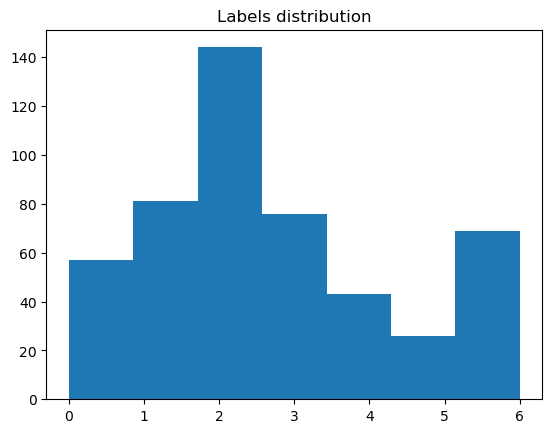

In [7]:
plt.hist(labels,bins=7);
plt.title("Labels distribution")
plt.show()

Might not need but in case

In [8]:
normalized_features = normalize(features, axis=0)

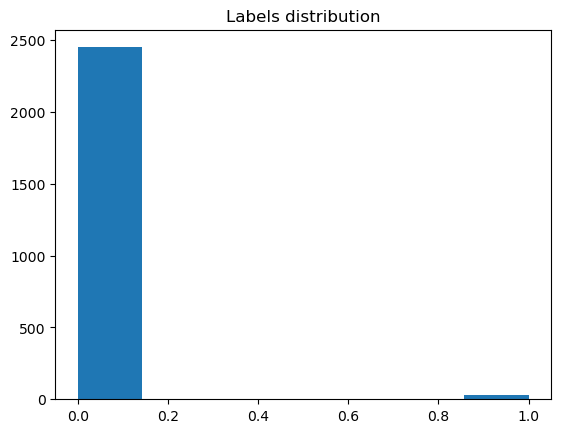

In [9]:
plt.hist(features[:,1],bins=7);
plt.title("Labels distribution")
plt.show()

In [10]:
num_unique_values = np.apply_along_axis(lambda x: len(np.unique(x)), axis=0, arr=features)
num_same_value_columns = np.sum(num_unique_values == 1)

print(f"Number of columns with the same value for all nodes: {num_same_value_columns}")

column_averages = np.mean(features, axis=0)
print("Averages of all columns:")
for idx, avg in enumerate(column_averages):
    print(f"Column {idx + 1}: {avg}")

Number of columns with the same value for all nodes: 5
Averages of all columns:
Column 1: 0.006048387096774193
Column 2: 0.012096774193548387
Column 3: 0.02620967741935484
Column 4: 0.025
Column 5: 0.06330645161290323
Column 6: 0.0024193548387096775
Column 7: 0.01129032258064516
Column 8: 0.0032258064516129032
Column 9: 0.011693548387096775
Column 10: 0.0024193548387096775
Column 11: 0.005241935483870968
Column 12: 0.0032258064516129032
Column 13: 0.010080645161290322
Column 14: 0.008064516129032258
Column 15: 0.004032258064516129
Column 16: 0.0036290322580645163
Column 17: 0.00564516129032258
Column 18: 0.0032258064516129032
Column 19: 0.0064516129032258064
Column 20: 0.21088709677419354
Column 21: 0.0012096774193548388
Column 22: 0.004435483870967742
Column 23: 0.0016129032258064516
Column 24: 0.008064516129032258
Column 25: 0.0012096774193548388
Column 26: 0.02661290322580645
Column 27: 0.02379032258064516
Column 28: 0.013306451612903225
Column 29: 0.0032258064516129032
Column 30: 0

In [11]:
max_value = np.max(features)
min_value = np.min(features)
print(max_value, min_value)

1 0


In [12]:
edge_index[1].dtype

torch.float32

# 3. Making the DATA object for training
- x: features
- edge_index: edge_index[0] (weight 1 for all edges)
- y: labels
- train_mask: training indices
- test_mask: testting indices

In [13]:
x = torch.tensor(features, dtype=torch.float)

In [14]:
# making the masks
train_val_indices = data_splits['idx_train']
test_indices = data_splits['idx_test']

train_val_mask = torch.zeros(features.shape[0], dtype=torch.bool)
train_val_mask[train_val_indices] = 1
test_mask = torch.zeros(features.shape[0], dtype=torch.bool)
test_mask[test_indices] = 1

Making an extended labels tensor for easy training

In [15]:
labels_tensor = torch.zeros(features.shape[0], dtype=torch.int64)
labels_i = 0
for i in train_val_indices:
    labels_tensor[i] = labels[labels_i]
    labels_i += 1

labels_tensor

tensor([5, 0, 0,  ..., 0, 0, 0])

Creating a validation mask

In [30]:
def create_train_val_masks(train_val_mask, val_ratio):
    labeled_indices = train_val_mask.nonzero().view(-1)
    permuted_indices = torch.randperm(labeled_indices.size(0))
    
    shuffled_indices = labeled_indices[permuted_indices]
    
    num_val_nodes = int(val_ratio * len(labeled_indices))
    
    val_indices = shuffled_indices[permuted_indices[:num_val_nodes]]
    train_indices = shuffled_indices[permuted_indices[num_val_nodes:]]
    
    train_mask = torch.zeros(NODES, dtype=torch.bool)
    train_mask[train_indices] = 1
    val_mask = torch.zeros(NODES, dtype=torch.bool)
    val_mask[val_indices] = 1
    return train_mask, val_mask

val_ratio = 0.2
train_mask, val_mask = create_train_val_masks(train_val_mask, val_ratio)

In [17]:
labeled_indices = train_val_mask.nonzero().view(-1)
permuted_indices = torch.randperm(labeled_indices.size(0))

shuffled_indices = labeled_indices[permuted_indices]

val_ratio = 0.2
num_val_nodes = int(val_ratio * len(labeled_indices))

val_indices = shuffled_indices[permuted_indices[:num_val_nodes]]
train_indices = shuffled_indices[permuted_indices[num_val_nodes:]]

train_mask = torch.zeros(features.shape[0], dtype=torch.bool)
train_mask[train_indices] = 1
val_mask = torch.zeros(features.shape[0], dtype=torch.bool)
val_mask[val_indices] = 1

Now we have everything for the data object

In [18]:
data = Data(x=x, edge_index=edge_index[0], y=labels_tensor, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data

Data(x=[2480, 1390], edge_index=[2, 10100], y=[2480], train_mask=[2480], val_mask=[2480], test_mask=[2480])

# 4. Constructing Model

In [19]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, num_hidden)
        self.conv2 = GCNConv(num_hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

# 5. Training

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

In [21]:
model = GCN(num_node_features=data.x.shape[1], 
            num_hidden=16,
            num_classes=7
           ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch {0}: {1}'.format(epoch, loss.item()))

Epoch 0: 1.9486517906188965
Epoch 10: 0.9545109272003174
Epoch 20: 0.4147993326187134
Epoch 30: 0.21304836869239807
Epoch 40: 0.15480537712574005
Epoch 50: 0.10405351966619492
Epoch 60: 0.09369416534900665
Epoch 70: 0.08053649961948395
Epoch 80: 0.08238577842712402
Epoch 90: 0.08064993470907211
Epoch 100: 0.06815881282091141
Epoch 110: 0.08159606903791428
Epoch 120: 0.08091622591018677
Epoch 130: 0.058172229677438736
Epoch 140: 0.06300457566976547
Epoch 150: 0.061605025082826614
Epoch 160: 0.06324642896652222
Epoch 170: 0.05258077010512352
Epoch 180: 0.06480573862791061
Epoch 190: 0.061357785016298294


In [22]:
model.eval()
pred = model(data).argmax(dim=1)

In [23]:
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 1.0000


In [24]:
pred[train_val_mask]

tensor([5, 0, 2, 0, 6, 5, 1, 6, 1, 2, 0, 6, 2, 3, 6, 2, 2, 6, 4, 2, 2, 3, 4, 0,
        3, 3, 2, 0, 5, 4, 6, 0, 1, 2, 2, 0, 2, 1, 3, 2, 4, 0, 2, 0, 2, 1, 2, 4,
        1, 0, 1, 6, 2, 2, 2, 4, 6, 0, 2, 0, 5, 5, 3, 2, 5, 1, 2, 1, 2, 2, 6, 2,
        2, 5, 4, 2, 2, 0, 1, 0, 0, 2, 3, 5, 1, 6, 1, 0, 2, 2, 2, 1, 1, 1, 4, 0,
        2, 3, 1, 1, 0, 2, 2, 0, 2, 2, 2, 2, 3, 3, 1, 3, 3, 3, 6, 2, 2, 2, 6, 2,
        2, 1, 2, 2, 3, 1, 6, 2, 1, 2, 2, 6, 2, 2, 6, 2, 2, 0, 0, 1, 6, 2, 2, 3,
        2, 5, 0, 3, 6, 6, 1, 1, 2, 3, 3, 5, 3, 4, 4, 2, 2, 2, 2, 6, 6, 6, 2, 4,
        3, 3, 1, 0, 3, 2, 2, 2, 4, 4, 2, 5, 4, 1, 3, 3, 5, 3, 6, 6, 2, 3, 3, 1,
        2, 6, 6, 3, 5, 6, 3, 4, 1, 3, 6, 6, 0, 2, 3, 6, 2, 6, 1, 4, 4, 3, 4, 1,
        4, 3, 0, 2, 3, 3, 0, 1, 2, 2, 0, 2, 2, 6, 6, 1, 2, 2, 5, 5, 0, 2, 0, 0,
        1, 0, 6, 3, 2, 1, 1, 2, 2, 2, 2, 2, 6, 0, 0, 2, 1, 6, 2, 1, 2, 0, 6, 1,
        6, 2, 3, 6, 6, 6, 2, 4, 4, 0, 0, 6, 0, 4, 4, 4, 4, 6, 6, 3, 1, 1, 2, 2,
        2, 5, 6, 2, 3, 3, 3, 3, 3, 2, 2,

In [25]:
# examples_test = []
# for i, p in zip(data_splits['idx_train'], labels):
#     examples_test.append((i, p))
# examples_test.sort()
# examples_test
# exxx = [b for a, b in examples_test]
# torch.tensor(exxx, dtype=torch.int64)

In [26]:
test_preds = pred[data_splits['idx_test']].cpu()
test_preds

tensor([1, 3, 2,  ..., 4, 1, 3])

In [27]:
# np.savetxt('submission.txt', test_preds, fmt='%d')

In [28]:
for z in test_preds:
    print(z.item())

1
3
2
1
1
2
3
1
1
1
5
1
2
2
4
1
3
2
2
3
2
1
2
4
0
1
3
2
4
4
2
1
4
3
6
3
2
2
3
2
2
0
2
3
3
2
5
6
2
2
3
2
1
3
6
1
2
4
1
3
3
6
2
6
1
6
5
0
2
6
1
4
0
1
0
2
0
3
1
3
6
1
1
6
2
1
2
6
5
2
6
1
0
3
6
3
6
4
3
3
1
6
5
5
0
2
1
1
2
2
6
2
6
1
2
1
3
6
2
6
0
4
2
3
1
0
6
0
0
2
1
0
0
6
6
4
3
2
6
3
3
1
2
3
4
5
0
1
3
0
2
2
2
2
0
2
4
1
2
5
2
3
2
1
2
2
3
3
2
3
2
3
0
1
1
1
6
2
4
3
1
2
6
2
6
0
3
6
2
3
5
3
5
2
2
2
0
1
0
2
2
3
1
4
1
6
1
2
0
2
3
6
2
3
2
0
2
6
2
4
6
3
1
2
2
3
4
0
6
2
2
1
4
1
3
2
3
3
2
6
0
6
4
1
1
6
2
6
2
2
6
2
0
2
0
6
2
1
2
4
2
3
3
6
5
1
5
3
4
2
2
2
4
0
3
1
2
4
4
1
3
0
3
0
3
6
5
4
3
2
2
3
2
2
2
0
3
6
6
6
2
5
1
2
6
1
2
6
5
2
5
4
1
3
3
4
0
6
2
0
2
2
6
2
2
2
2
3
6
3
2
1
6
4
2
2
2
5
6
3
2
6
2
0
2
6
0
1
0
1
4
5
5
1
2
1
6
1
5
0
1
4
1
3
6
3
3
5
5
2
0
6
5
5
2
6
0
1
3
6
2
2
1
1
6
2
3
1
3
0
5
2
1
4
4
2
2
2
6
0
2
2
3
0
2
3
2
0
3
2
6
2
1
0
5
1
3
5
6
6
6
1
2
0
2
3
5
2
3
1
6
0
5
2
6
4
6
5
2
5
1
2
3
5
3
2
6
3
2
6
5
4
0
0
2
2
0
1
6
2
3
1
3
4
1
6
6
3
3
2
1
2
0
4
2
2
3
0
2
6
6
1
1
2
4
6
3
3
1
4
2
2
1
2
5
6
5
2
3
1


In [118]:
NUM_FOLDS = 5
EPOCHS = 200

val_losses = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(num_node_features=data.x.shape[1], 
        num_hidden=16,
        num_classes=7).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for fold in range(NUM_FOLDS):
    train_mask, val_mask = create_train_val_masks(train_val_mask, val_ratio)
    
    data = Data(x=x, edge_index=edge_index[0], y=labels_tensor, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
    data = data.to(device)
    
    model.train()   
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        # if epoch % 10 == 0:
        #     print('Epoch {0}: {1}'.format(epoch, loss.item()))
    

    model.eval()
    with torch.no_grad():
        val_out = model(data)
        val_loss = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])
        val_losses.append(val_loss.item())
    
    print(f'Fold {fold + 1}: Validation Loss: {val_loss.item()}')

avg_val_loss = sum(val_losses) / len(val_losses)
print(f'Average Validation Loss: {avg_val_loss}')

Fold 1: Validation Loss: 0.8596091866493225
Fold 2: Validation Loss: 0.37561559677124023
Fold 3: Validation Loss: 0.7018597722053528
Fold 4: Validation Loss: 0.707426130771637
Fold 5: Validation Loss: 0.4968465566635132
Average Validation Loss: 0.6282714486122132


In [119]:
model.eval()
pred_Kfold = model(data).argmax(dim=1)

correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9597


In [120]:
pred_Kfold[test_indices]

tensor([1, 3, 2,  ..., 4, 1, 3], device='cuda:0')

In [121]:
with open('./submission.txt', 'r') as file:
    lines = file.readlines()

prev_sub = [int(line) for line in lines]

In [122]:
def compare(prev_sub, curr_pred, two_current=False):
    c = 0
    
    if two_current:
        for q, w in zip(prev_sub[test_indices], curr_pred[test_indices]):
            if q.item() != w.item():
                c += 1
        return c
    
    for q, w in zip(prev_sub, curr_pred[test_indices]):
        if q != w.item():
            c += 1
    return c

In [123]:
compare(prev_sub, pred_Kfold)

153

In [124]:
compare(prev_sub, pred)

170

In [125]:
compare(pred, pred_Kfold, two_current=True)

156